In [1]:
# Habilit librerias
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Buscamos y abrimos archivo de sea surface temperature (SST)
file = 'HOT_sst.csv'
df = pd.read_csv(file,
                  index_col='time',parse_dates=True) # Habilito la interpretación de tiempo

In [4]:
# Calulamos una climatología estacional
df_30years = df[(df.index.year>=1850)           # definimos para ello un periodo de  30 años
                & (df.index.year<1880)]         # como base 
clim = df_30years['sst'].to_xarray().groupby(   # Agrupamos por meses para crearla
    'time.month').mean('time')                  #

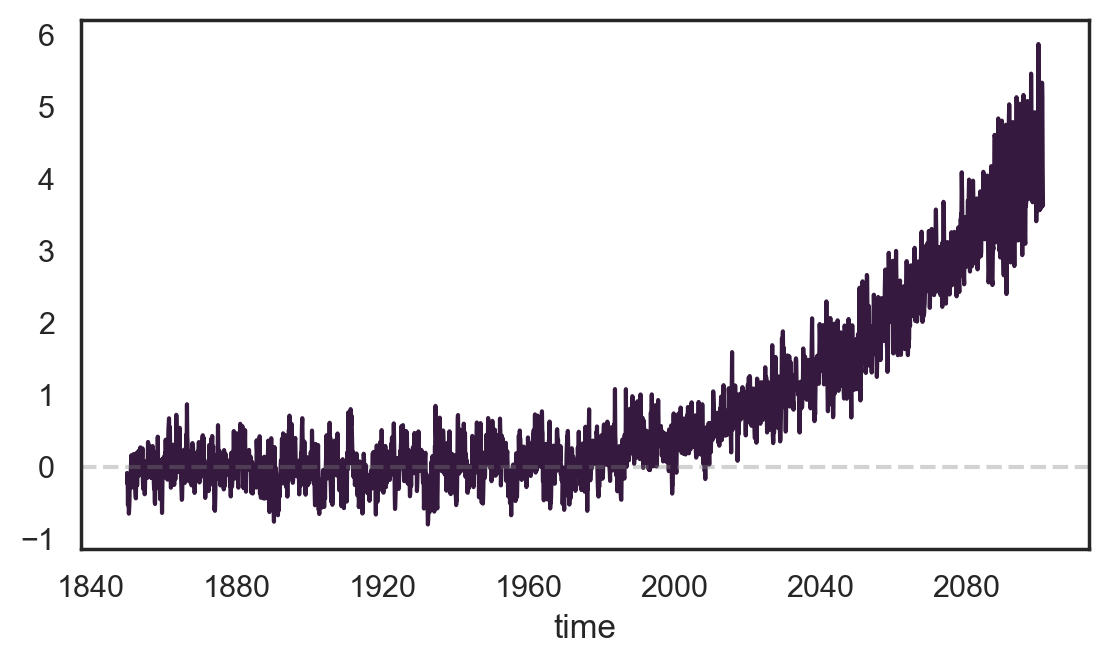

In [11]:
# Dibujamos una serie temporal de la anomalía
# Para ello calculamos las medias mensuales
# y a ellas les extraemos la climatología

df_mon = df.resample('1M').mean()

anom_clim = df_mon['sst'].to_xarray().groupby(   # 
    'time.month') - clim

sns.set_theme(style="white")
sns.set_palette(sns.color_palette("rocket"))
f, ax = plt.subplots(figsize=(6.5, 3.5),
                     dpi=200)
sns.lineplot(data=anom_clim.to_pandas())
plt.axhline(0,ls='--',color='grey',
           alpha=0.35)  # Añadimos una linea a 0 para ver si la anomalía es positiva/negativa
plt.show()

In [21]:
### Podríamos también calcular una serie temporal "suavizada" usando Spline
from scipy.interpolate import UnivariateSpline

# Creating a spline regression model
xs = anom_clim.time.dt.year 
spl = UnivariateSpline(xs, anom_clim.values,k=3)  # 3 Degrees of freedom

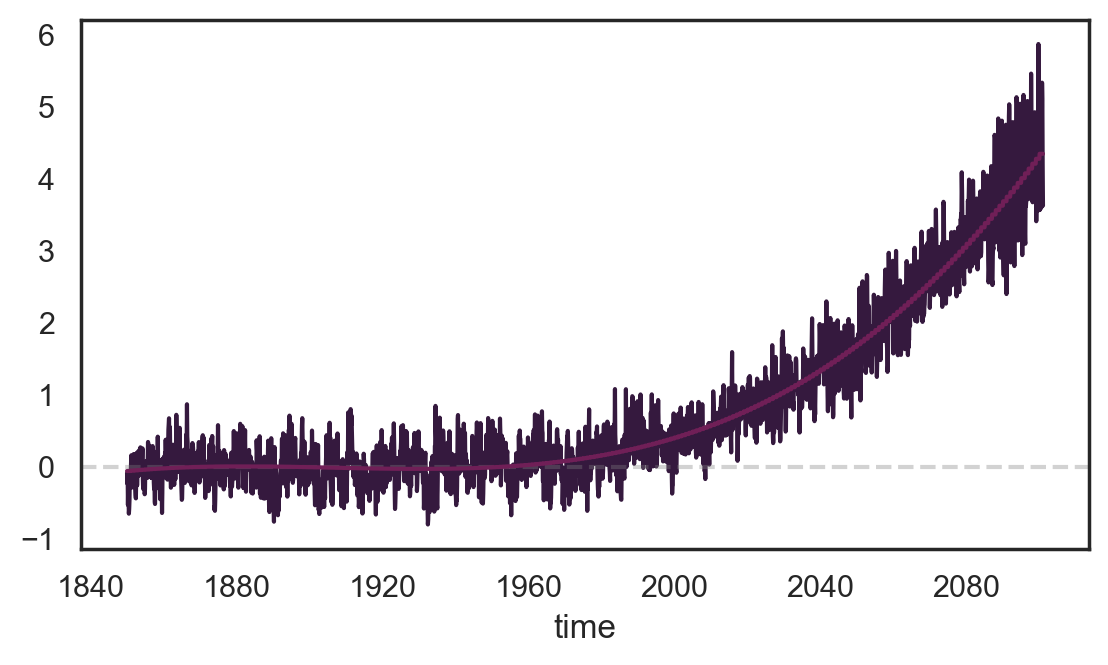

In [22]:
## Hacemos la misma figura anterior incorporando nuestro suavizado
sns.set_theme(style="white")
sns.set_palette(sns.color_palette("rocket"))
f, ax = plt.subplots(figsize=(6.5, 3.5),
                     dpi=200)
sns.lineplot(data=anom_clim.to_pandas())
plt.axhline(0,ls='--',color='grey',
           alpha=0.35)  
sns.lineplot(y=pd.Series(spl(xs)),  # La serie temporal será la spline
             x=anom_clim.time)      # el vector tiempo es el mismo que el de la anomalía
plt.show()


In [31]:
### También podríamos hacerlo usando un "moving average"
roll_anom = anom_clim.to_pandas().rolling(
    window=10).mean()# Tail-rolling average transform (10 years in this case)


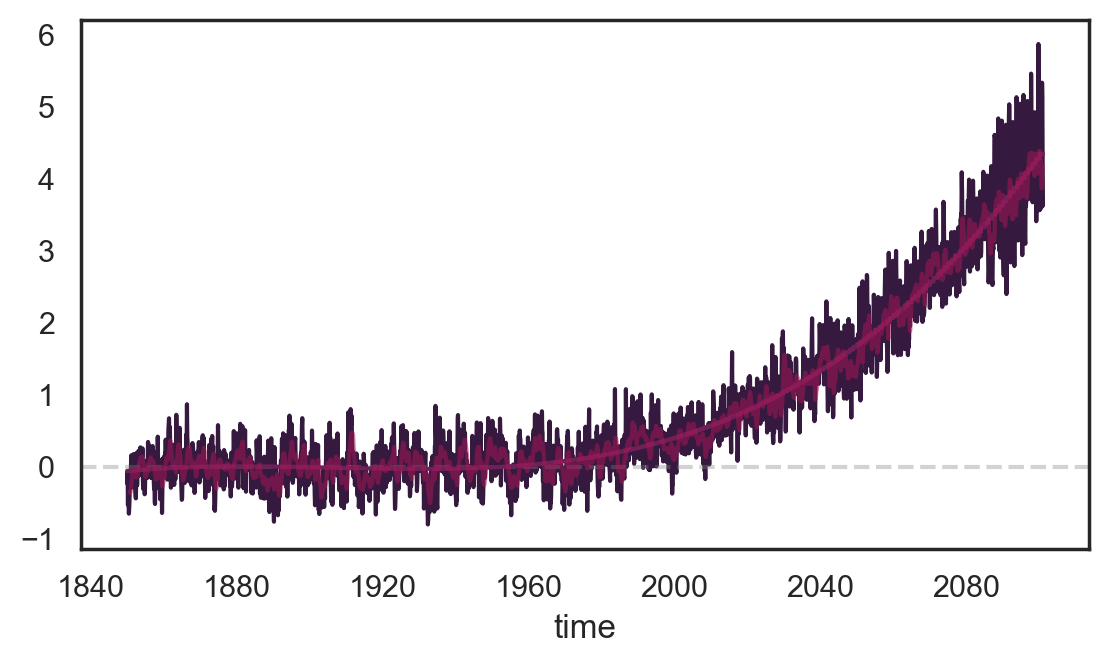

In [33]:
## Hacemos la misma figura anterior incorporando nuestro segundo suavizado
sns.set_theme(style="white")
sns.set_palette(sns.color_palette("rocket"))
f, ax = plt.subplots(figsize=(6.5, 3.5),
                     dpi=200)
sns.lineplot(data=anom_clim.to_pandas())
plt.axhline(0,ls='--',color='grey',
           alpha=0.35)  
sns.lineplot(y=pd.Series(spl(xs)),  # La serie temporal será la spline
             x=anom_clim.time)      # el vector tiempo es el mismo que el de la anomalía
sns.lineplot(y=roll_anom,           # La serie temporal será la rolling mean
             x=anom_clim.time,
             alpha=0.5)    
plt.show()

In [56]:
# Calculamos cuando una serie temporal supera un cierto umbral
(df_mon > (clim.quantile(.95).values))                      # Éste sería nuestro supuesto

# Para ello podemos usar la función "where" de xarray
umbral = df_mon.to_xarray().where(                          # Convertimos a xarray
    df_mon.to_xarray()['sst'] > clim.quantile(.99).values,  # Buscamos nuestro umbral
    drop=True)                                              # Nos quedamos con aquellos momentos que se cumple

umbral['sst'][0]

<xarray.DataArray 'sst' ()>
array(27.89384403)
Coordinates:
    time     datetime64[ns] 1852-09-30